In [3]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import os
from urllib.parse import urlparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'
import numpy as np
from matplotlib.ticker import FuncFormatter



# enable horizontal scroll of data frame in Jupyter lab
from IPython.display import display, HTML
display(HTML("<style>.jp-OutputArea-output {display:flex}</style>"))

pd.options.display.html.use_mathjax = False
pd.options.display.min_rows = 100
pd.options.display.max_rows = 100


In [220]:
# PART A: DOWNLOAD ALL OF ELECTIONLINE WEEKLY

# import requests
# from bs4 import BeautifulSoup
# import os

# YEARS = reversed(range(2011, 2024))

# # Define user-agent to simulate a web browser request
# headers = {
#     "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36"
# }

# base_url = 'https://electionline.org'

# for year in YEARS:
#     dir_path = f"electionline-weekly/{year}"
#     os.makedirs(dir_path, exist_ok=True)
    
#     url = f"{base_url}/electionline-weekly/{year}"
    
#     # Send an HTTP GET request with headers
#     response = requests.get(url, headers=headers)

#     soup = BeautifulSoup(response.text, 'html.parser')
    
#     weeks = soup.find('ul', class_='weeks').find_all('li')
#     weeks = [f"{base_url}{week.find('a')['href']}" for week in weeks]

#     for week in weeks:
#         response = requests.get(week, headers=headers)
#         with open(f"{week.split('electionline.org/')[-1]}.html", 'w') as f:
#             f.write(response.text)


In [114]:
# go through all the saved HTML, and make each
# paragraph a row in a pandas data frame.
# use regex to pull out key details

YEARS = reversed(range(2011, 2024))

job_df = pd.DataFrame()

for year in YEARS:
    dir = f"electionline-weekly/{year}"
    weeks = os.listdir(dir)

    for week in weeks:
        date = week[:5]
        
        with open(os.path.join(dir, week)) as f:
            text = f.read()
        soup = BeautifulSoup(text, 'html.parser')
    
        # Find all divs with the class 'article-wrapper'
        divs_with_class = soup.find_all('div', class_='article-wrapper')
    
    
        for div in divs_with_class:
            h2_tags = div.find_all('h2', string=re.compile(r'^job', re.I))
            
            if h2_tags:
                for h2_tag in h2_tags:
                    # Find all p elements within the div containing the matched h2 tag
                    # Skip the first paragraph
                    job_paragraphs = div.find_all('p')[1:]  

                    # Skip intro and empty paragraphs
                    job_paragraphs = [para for para in job_paragraphs if (not para.text.startswith('electionlineWeekly')) and (len(para.text)>10)]    
                    
                    for paragraph in job_paragraphs:
                        # Extract job information from the paragraph
                        link = paragraph.find('a')
                        job_title = link.get_text() if link is not None else ""
                        
                        employer_match = re.search(r'\/a>[^,]*(?:,|-)\s*([^-–—]*)', str(paragraph))
                        employer = employer_match.group(1) if employer_match else ""
                        
                        # salary_match = re.search(r'Salary[^:]*:\s(.*?)(?=\.\s)', paragraph.get_text())
                        salary_match = re.search(r'Salary[^:]*:\s(.*?)(?=\.\s|Dead)', paragraph.get_text())
                        salary = salary_match.group(1) if salary_match else ""
                        
                        description = paragraph.get_text()
                        job_link = link['href'] if link is not None else ""
    
                        # Append job information to the list as a dictionary
                        new_row = pd.DataFrame({'Job Title': job_title,
                                                'Employer': employer,
                                                'Salary': salary,
                                                'Description': description,
                                                'Link': job_link,
                                                'Date': date,
                                                'Year': year}, index=[0])
                        job_df = pd.concat([job_df, new_row], ignore_index=True)

# some cleanup!

job_df = job_df.drop_duplicates(subset=['Job Title', 'Employer', 'Salary', 'Link'], keep='last')

# exclude listings from some of the top URLs belonging to private employers
excluded_domains = ['dominionvoting.com',
                   'clearballot.com',
                   'electioninnovation.org',
                   'runbeck.net',
                   'rockthevote.com',
                   'hartintercivic.com',
                   'fordfoundation.org',
                   'techandciviclife.org',
                   'bipartisanpolicy.org',
                   'cdt.org',
                   'ericstates.org',
                   'centerfortechandciviclife.recruitee.com',
                   'democracy.works',
                   'electionreformers.org',
                   'verifiedvoting.org']

def is_not_excluded_domain(url):
    netloc = urlparse(url).netloc.replace('www.', '')
    return netloc not in excluded_domains

job_df = job_df[job_df['Link'].apply(is_not_excluded_domain)]

def pay_basis(x):
    x = x.lower()
    if re.search('hr|hour', x):
        return 'hourly'
    elif re.search('month', x):
        return 'monthly'
    elif re.search('biweek', x):
        return 'biweekly'
    elif re.search('week', x):
        return 'weekly'
    else:
        return 'yearly'

job_df['Pay basis'] = job_df['Salary'].apply(pay_basis)

 # just a guess to correct the typo. It could be 110, or 101,... not sure.
job_df.loc[(job_df['Job Title']=='Elections Manager') & (job_df['Employer'] == 'Anoka County, Minnesota'), 'Salary']='$88,628-$101,878'

def clean_salary(x):
    cleaned_string = x.replace(' to ', '-').replace(' and ', '-')
    cleaned_string = cleaned_string.replace('Grade 14-', '')
    cleaned_string = re.sub(f'[^0-9\.\-–—]', '', cleaned_string) # get rid of things that aren't dashes and hyphens, periods, en, or em dashes.
    return cleaned_string.replace('–', '-').replace('—', '-') # replace en and em dashes with hyphens

job_df['Clean salary'] = job_df['Salary'].apply(clean_salary)

def split_salary(x, end='low'):
    # pattern = r'[-–—]'  # Matches hyphen, en dash, or em dash
    pattern = '-'
    ends = [part.strip().strip('$').strip('.') for part in re.split(pattern, x)]
    if end=='low':
        return ends[0]
    else:
        if len(ends) > 1:
            return ends[1]
        else:
            return None
        
job_df['Salary low end'] = pd.to_numeric(job_df['Clean salary'].apply(lambda x: split_salary(x, end='low')))
job_df['Salary high end'] = pd.to_numeric(job_df['Clean salary'].apply(lambda x: split_salary(x, end='high')))

# todo: replace K with 000. if it's under 100, assume hourly.


# yearly = job_df[job_df['Pay basis']=='yearly']


# job_df.sort_values('Salary high end', ascending=False)

In [115]:
# use scrapeghost to have GPT-3.5 pull
# out features in the data. it will probably
# be better than my regex.

suffix = '_sg'
schema = {
        "job_title": "string",
        "employer": "string",
        "state_full_name": "string",
        "salary_low_end": "float",
        "salary_high_end": "float",
        "pay_basis": "yearly, monthly, hourly, etc.",
                 }
scrape_job_description = SchemaScraper(schema=schema)

schema_renamed = {f'{key}{suffix}': value for key, value in schema.items()}
job_df[list(schema_renamed.keys())] = None

In [157]:
cost = 0

# extra_rows = []

# row = 6973
for row in tqdm(job_df.loc[row:].index):
    description = job_df.loc[row]['Description']
    response = scrape_job_description(description)
    if isinstance(response.data, list): # rarely, it will be a list because multiple jobs are in one paragraph
        extra_rows += response.data
    else: # vast majority of rows
        data = {f'{key}{suffix}': value for key, value in response.data.items()}
        job_df.loc[row, data.keys()] = data.values()

    cost += response.total_cost
# print(f"Running Cost: ${cost:.4f}")

extra_df = pd.DataFrame(extra_rows)
extra_df.columns = list(schema_renamed.keys())
job_df = pd.concat([job_df, extra_df])


100%|███████████████████████████████████████████████████████| 70/70 [01:41<00:00,  1.45s/it]


In [228]:
# some cleanup

job_df['pay_basis_sg'] = job_df['pay_basis_sg'].str.lower()

yearly_synonyms = ['salary', 'annually']
for syn in yearly_synonyms:
    job_df['pay_basis_sg'] = job_df['pay_basis_sg'].str.replace(syn, 'yearly')

In [229]:
job_df.to_pickle('jobs.pickle')
job_df.to_csv('jobs.csv')

In [4]:
job_df = pd.read_pickle('jobs.pickle')

job_df.replace('', np.nan, inplace=True)

job_df.loc[(job_df['Job Title']=='Elections Manager') & (job_df['Employer'] == 'Anoka County, Minnesota'), 'salary_high_end_sg'] = 101878 # correct typo

# find EAC listing that is doubled and has incorrect salary. get rid of the double and fix the salary. I'm pretty sure the correction is accurate: https://www.federalpay.org/gs/2018/districtofcolumbia
eac_indices = job_df[job_df['Link'] == 'https://www.usajobs.gov/GetJob/ViewDetails/511964200'].index
job_df = job_df.drop(eac_indices[0])
job_df.loc[eac_indices[1], 'Salary'] = '$119,597-$141328'
job_df.loc[eac_indices[1], 'Clean salary'] = '119597-141328'
job_df.loc[eac_indices[1], 'Salary low end'] = 119597.0
job_df.loc[eac_indices[1], 'salary_low_end_sg'] = 119597.0

gwin_index = job_df[job_df['Job Title']=='Bilingual Resources and Marketing Specialist'].index
job_df.loc[gwin_index, 'Salary'] = '$42,162-$48,486'
job_df.loc[gwin_index, 'Clean salary'] = '42162-48486'
job_df.loc[gwin_index, 'Salary low end'] = 42162.0
job_df.loc[gwin_index, 'Salary high end'] = 48486.0
job_df.loc[gwin_index, 'salary_low_end_sg'] = 42162.0
job_df.loc[gwin_index, 'salary_high_end_sg'] = 48486.0

job_df['salary_mean'] = job_df[['salary_low_end_sg', 'salary_high_end_sg']].mean(axis=1)

# adjust monthly salaries
monthly = job_df['pay_basis_sg'] == 'monthly'
for col in ['salary_mean', 'salary_low_end_sg', 'salary_high_end_sg']:
    job_df.loc[monthly, col] = job_df.loc[monthly, col]*12
    

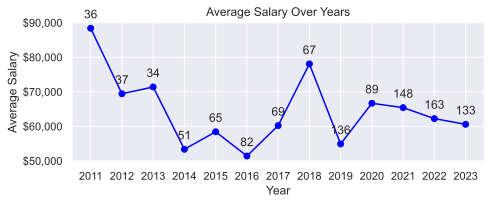

In [15]:

salary_means = job_df.groupby('Year')['salary_mean'].mean()

year_counts = job_df.groupby('Year').size()

# Plot
plt.figure(figsize=(7,3))
salary_means.plot(kind='line', marker='o', color='blue')


# Define a custom y-axis tick formatter
def currency_formatter(x, pos):
    return "${:,.0f}".format(x)

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(currency_formatter))


plt.title('Average Salary Over Years')
plt.ylabel('Average Salary')
plt.xlabel('Year')
plt.grid(True)

# Annotate each point with the number of rows (job listings) for the year
for year, (mean, count) in enumerate(zip(salary_means, year_counts)):
    plt.annotate(str(count), (salary_means.index[year], salary_means.iloc[year]), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.xticks(range(2011, 2024));
plt.show()


In [16]:
# sns.lineplot(data=job_df, x="Year", y="salary_mean", errorbar=None) # for error bar


In [132]:
pd.set_option('display.max_colwidth', 10) # set length of description
comparison_cols = ['Salary', 'Salary low end', 'salary_low_end_sg', 'Salary high end', 'salary_high_end_sg', 'Pay basis', 'pay_basis_sg', 'Job Title', 'job_title_sg', 'Employer', 'employer_sg', 'state_full_name_sg', 'Description']
job_df.sample(2)[comparison_cols]

# job_df[job_df['salary_low_end_sg'].isna() & job_df['salary_high_end_sg'].notna()][comparison_cols]

,Salary,Salary low end,salary_low_end_sg,Salary high end,salary_high_end_sg,Pay basis,pay_basis_sg,Job Title,job_title_sg,Employer,employer_sg,state_full_name_sg,Description
3065,"$63,063 -$84,513",63063.0,63063.0,84513.0,84513.0,yearly,yearly,Staff Attorney,"Staff Attorney, Voting Rights Practice Group","Voting Rights Practice Group, Disability Rights California",Disability Rights California,NaN,"Staff Attorney, Voting Rights Practice Group, Disability Rights California— DRC’s Voting Rights ..."
6637,"$31,782-$55,307",31782.0,31782.0,55307.0,55307.0,yearly,yearly,Elections Compliance Officer,Elections Compliance Officer,New Mexico Secretary of State’s Office </strong>,New Mexico Secretary of State’s Office,New Mexico,"Elections Compliance Officer, New Mexico Secretary of State’s Office — position will work as an ..."
